# Problem

- current conv AE has a "deep" latent layer... how do we deal with that?
- two options:
    - see if there's a way to go from a conv net to vector and back again, or
        - let's try this
    - see if we can modify the vade to take a 2d latent layer
    

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import torch
import torch.utils.data
# from torchvision import datasets, transforms
import numpy as np
import argparse
from udlp.autoencoder.denoisingAutoencoder import DenoisingAutoencoder
from pacdataset import PacDataset
from matplotlib import pyplot as plt

from torchvision import transforms

from conv_ae import autoencoder
from torch import nn
from torch.autograd import Variable

%matplotlib inline

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
t33 = torch.autograd.Variable( torch.zeros((1,1,121,145)))
t33
# > 128 1 121 145
con1 = nn.Conv2d(1, 16, 3, stride=3, padding=1)  # b, 16, 10, 10 # floor((121 - 3 + 2) / 3) + 1 = 41
ct1 = nn.ConvTranspose2d(1, 16, 3, stride=3, padding=1)
r1 = nn.ReLU(True)
mp1 = nn.MaxPool2d(2, stride=2)  # b, 16, 5, 5 # floor(41 - 2/ 2) + 1 = 20
con2 = nn.Conv2d(16, 8, 3, stride=2, padding=1)  # b, 8, 3, 3  # floor((20 -3 + 2) / 2 ) + 1 = 10
ct2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1)
r2 = nn.ReLU(True)
mp2 = nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2 # (10 - 2 / 1) + 1 = 9 (match!)



print(f"t33: {t33.shape}")
x = con1(t33)
print(f"con1: {x.shape}")
x = r1(x)
# print(f"r1: {x.shape}")
x = mp1(x)
print(f"mp1: {x.shape}")
x = con2(x)
print(f"con2: {x.shape}")
x = r2(x)
# print(f"r2: {x.shape}")
x = mp2(x)
encoder_shape = x.shape
print(f"mp2: {x.shape}")
x = x.view(-1)
x = x.view(encoder_shape)
x = nn.ConvTranspose2d(8, 8, 2, stride=1, padding=0)(x)
print(f"what?: {x.shape}")
x = nn.ConvTranspose2d(8, 16, 2, stride=2, padding=0)(x)
print(f"what2: {x.shape}")
x = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=0)(x)
print(f"what3: {x.shape}")
x = nn.ConvTranspose2d(16, 1, 3, stride=3, padding=1)(x)
print(f"what3: {x.shape}")



t33: torch.Size([1, 1, 121, 145])
con1: torch.Size([1, 16, 41, 49])
mp1: torch.Size([1, 16, 20, 24])
con2: torch.Size([1, 8, 10, 12])
mp2: torch.Size([1, 8, 9, 11])
what?: torch.Size([1, 8, 10, 12])
what2: torch.Size([1, 16, 20, 24])
what3: torch.Size([1, 16, 41, 49])
what3: torch.Size([1, 1, 121, 145])


In [2]:
# input[128 x 1 x 112 x 136] has 1949696 elements, while target[128 x 1 x 121 x 145]

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            # > [128, 8, 9, 11])
#             nn.ConvTranspose2d(8, 16, 3, stride=2),   # 128, 16, 19, 23
#             nn.ReLU(True), # 128, 16, 19, 23
#             nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # 128, 8, 57, 69
#             nn.ReLU(True), #128, 8, 57, 69
#             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # 128, 1, 112, 136
#             nn.Tanh() # 128, 1, 112, 136
            nn.ConvTranspose2d(8, 8, 2, stride=1, padding=0),
            nn.ReLU(True),            
# print(f"what?: {x.shape}")
            nn.ConvTranspose2d(8, 16, 2, stride=2, padding=0),
# print(f"what2: {x.shape}")
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 16, 3, stride=2, padding=0),
            nn.ReLU(True),
# print(f"what3: {x.shape}")
            nn.ConvTranspose2d(16, 1, 3, stride=3, padding=1),
            nn.Tanh()
            
        )
        
#         img.shape torch.Size([128, 1, 121, 145])
#         encoder> torch.Size([128, 8, 9, 11])
#         ct1> torch.Size([128, 16, 19, 23])
#         relu1> torch.Size([128, 16, 19, 23])
#         ct2> torch.Size([128, 8, 57, 69])
#         relu2> torch.Size([128, 8, 57, 69])
#         ct3> torch.Size([128, 1, 112, 136])
#         tanh> torch.Size([128, 1, 112, 136])
#         img.shape torch.Size([128, 1, 121, 145])
        self.ct1 = nn.ConvTranspose2d(8, 16, 3, stride=2)
        self.relu1 = nn.ReLU(True)
        self.ct2 = nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1)
        self.relu2 = nn.ReLU(True)
        self.ct3 = nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1)
        self.th = nn.Tanh()

    def forward(self, y):
        x = self.encoder(y)
        encoder_shape = x.size()
        x = x.view(-1)
#         print(f'encoder> {x.shape}')
#         x = self.ct1(x)
#         print(f'ct1> {x.shape}')
#         x = self.relu1(x)
#         print(f'relu1> {x.shape}')
#         x = self.ct2(x) # b, 8, 15, 15
#         print(f'ct2> {x.shape}')
#         x = self.relu2(x)
#         print(f'relu2> {x.shape}')
#         x = self.ct3(x)  # b, 1, 28, 28
#         print(f'ct3> {x.shape}')
#         x = self.th(x)
#         print(f'tanh> {x.shape}')
        x = x.view(encoder_shape)
        x = self.decoder(x)
        return x
    
    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        pretrained_dict = torch.load(path, map_location=lambda storage, loc: storage)
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict) 
        self.load_state_dict(model_dict)


In [4]:
x.data.numpy().size

17545

In [3]:
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 100
batch_size = 64
learning_rate = 1e-3


model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)


In [4]:
datasets = {x: PacDataset(train=(x=='train'), 
                          root_dir = "/home/paperspace/data/pac2018/") 
#                           root_dir = "/Users/josephmann/Documents/Gheiratmand/sMRI competition/PAC Data/pac2018/") 
            for x in ['val','train']}

train_loader = torch.utils.data.DataLoader(
    datasets['train'],
    batch_size= batch_size, shuffle=True, num_workers=2, )
test_loader = torch.utils.data.DataLoader(
    datasets['val'],
    batch_size= batch_size, shuffle=False, num_workers=2)

In [7]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x



img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# dataset = MNIST('./data', transform=img_transform, download=True)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


for epoch in range(num_epochs):
    for data in train_loader:
        
        
#         img, _  = data
        img  = data
        img = Variable(img).cuda()
#         print(f"img.shape {img.shape}") 
        # ===================forward=====================
        output = model(img)
#         print(f"img.shape {img.shape}") 
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        print(f"img.shape {img.shape}") # with MNIST 96  1 28 28 
#         pic = to_img(output.cpu().data)
#         save_image(pic, './dc_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './conv_autoencoder1.pth')

epoch [1/100], loss:0.0782
img.shape torch.Size([38, 1, 121, 145])


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [2/100], loss:0.0722
epoch [3/100], loss:0.0642
epoch [4/100], loss:0.0612
epoch [5/100], loss:0.0555
epoch [6/100], loss:0.0558
epoch [7/100], loss:0.0473
epoch [8/100], loss:0.0443
epoch [9/100], loss:0.0416
epoch [10/100], loss:0.0375
epoch [11/100], loss:0.0382
img.shape torch.Size([38, 1, 121, 145])
epoch [12/100], loss:0.0377
epoch [13/100], loss:0.0378
epoch [14/100], loss:0.0370
epoch [15/100], loss:0.0342
epoch [16/100], loss:0.0371
epoch [17/100], loss:0.0323
epoch [18/100], loss:0.0332
epoch [19/100], loss:0.0291
epoch [20/100], loss:0.0308
epoch [21/100], loss:0.0302
img.shape torch.Size([38, 1, 121, 145])
epoch [22/100], loss:0.0307
epoch [23/100], loss:0.0286
epoch [24/100], loss:0.0268
epoch [25/100], loss:0.0271
epoch [26/100], loss:0.0273
epoch [27/100], loss:0.0259
epoch [28/100], loss:0.0256
epoch [29/100], loss:0.0249
epoch [30/100], loss:0.0238
epoch [31/100], loss:0.0230
img.shape torch.Size([38, 1, 121, 145])
epoch [32/100], loss:0.0229
epoch [33/100], loss

In [8]:
x.data.view(-1).size()

torch.Size([17545])

In [5]:
model.load_model('./conv_autoencoder.pth')

inputs shape torch.Size([64, 1, 121, 145])
min val for image: 1 tensor(0.)
64
0 (4, 121, 145)
inputs shape torch.Size([64, 1, 121, 145])
min val for image: 1 tensor(0.)
64
1 (4, 121, 145)
inputs shape torch.Size([64, 1, 121, 145])
min val for image: 1 tensor(0.)
64
2 (4, 121, 145)
inputs shape torch.Size([64, 1, 121, 145])
min val for image: 1 tensor(0.)
64
3 (4, 121, 145)


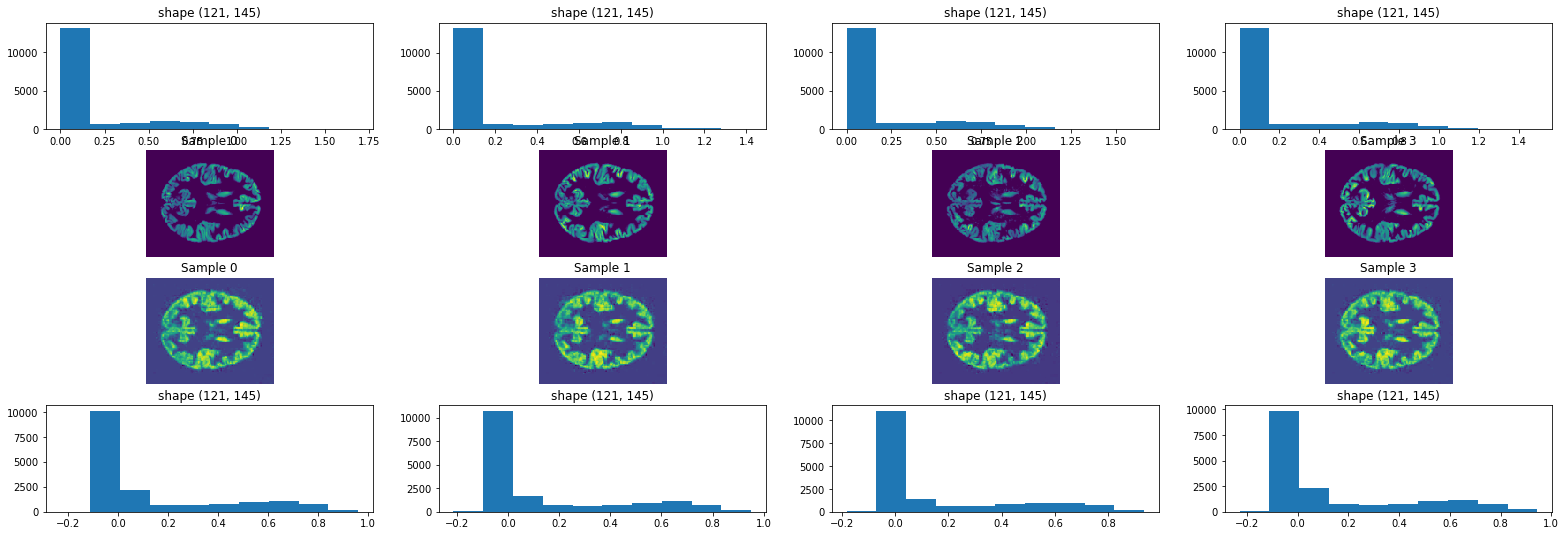

In [10]:
# face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
#                                     root_dir='faces/')
from matplotlib import pyplot as plt
from torch.autograd import Variable
fig = plt.figure(figsize=(12,12))

batch_size= 4
use_cuda = torch.cuda.is_available()
# for i in range(4): #len(datasets[0])):
figure = plt.figure(figsize=(27, 9))
i= 1
for batch_idx, inputs in enumerate(train_loader):    
    if batch_idx >= batch_size: 
        continue
    print("inputs shape", inputs.shape)
#     inputs = datasets['train'][i]
    print('min val for image:', i ,inputs.min())

#     inputs = inputs.view(inputs.size(0), -1).float()
    print(len(inputs))
    if use_cuda:
        inputs = inputs.cuda()
    inputs = Variable(inputs)
    outputs = model.forward(inputs)
#     f_sample = sdae.forward(datasets['train'][i])
#     sample = inputs.data.cpu().numpy().reshape(batch_size, 121,145)
    sample = inputs.data.cpu().numpy()[:4,0,:,:]
    sample_out = outputs.data.cpu().numpy()[:4,0,:,:] #.reshape(batch_size, 121,145)

    print(batch_idx, sample.shape)
i = 1
for b_idx in range(batch_size):

    ax = plt.subplot(4, 4, i)
    ax.set_title(f'shape {sample[b_idx].shape}')
#         ax.axis('off')
    ax.hist(sample[b_idx].flatten())
    i += 1

for b_idx in range(batch_size):

    ax = plt.subplot(4, 4, i)
    ax.set_title(f'Sample {b_idx}')
    ax.axis('off')
    ax.imshow(sample[b_idx])
    i += 1

for b_idx in range(batch_size):
    ax = plt.subplot(4, 4, i)
    ax.set_title(f'Sample {b_idx}')
    ax.axis('off')
    ax.imshow(sample_out[b_idx])
    i += 1

for b_idx in range(batch_size):

    ax = plt.subplot(4, 4, i)
    ax.set_title(f'shape {sample[b_idx].shape}')
#         ax.axis('off')
    ax.hist(sample_out[b_idx].flatten())
    i += 1

plt.show()

 

In [15]:
from udlp.clustering.vade_conv import VaDE
args_pretrain = 'model/pre_vade.pt'
args_pretrain = './conv_autoencoder.pth'

in_features = 17545 # and we ignore this
out_features = 500 # we ignore this
pretrainepochs = 20 
epochs = 2
z_dim = 50 # currently we ignore this... or maybe we don't...

lr = 0.001

vade = VaDE(input_dim=in_features, z_dim=z_dim, n_centroids=3, binary=True,
        encodeLayer=[4000,1000,500], decodeLayer=[500,1000,4000], debug=True)

if args_pretrain != "":
    print("Loading model from %s..." % args_pretrain)
    vade.load_model(args_pretrain)
print("Initializing through GMM..")
data = vade.initialize_gmm(train_loader)

Loading model from ./conv_autoencoder.pth...
encoder.0.weight torch.Size([16, 1, 3, 3])
encoder.0.bias torch.Size([16])
encoder.3.weight torch.Size([8, 16, 3, 3])
encoder.3.bias torch.Size([8])
decoder.0.weight torch.Size([8, 8, 2, 2])
decoder.0.bias torch.Size([8])
decoder.2.weight torch.Size([8, 16, 2, 2])
decoder.2.bias torch.Size([16])
decoder.4.weight torch.Size([16, 16, 3, 3])
decoder.4.bias torch.Size([16])
decoder.6.weight torch.Size([16, 1, 3, 3])
decoder.6.bias torch.Size([1])
ct1.weight torch.Size([8, 16, 3, 3])
ct1.bias torch.Size([16])
ct2.weight torch.Size([16, 8, 5, 5])
ct2.bias torch.Size([8])
ct3.weight torch.Size([8, 1, 2, 2])
ct3.bias torch.Size([1])
model dict **** 

theta_p torch.Size([3])
u_p torch.Size([50, 3])
lambda_p torch.Size([50, 3])
encoder.0.weight torch.Size([16, 1, 3, 3])
encoder.0.bias torch.Size([16])
encoder.3.weight torch.Size([8, 16, 3, 3])
encoder.3.bias torch.Size([8])
decoder.0.weight torch.Size([8, 8, 2, 2])
decoder.0.bias torch.Size([8])
decod

In [17]:
 vade.fit(train_loader, test_loader, lr=lr, batch_size=batch_size, num_epochs=epochs, anneal=True)

z size : torch.Size([64, 50])
outputs size : torch.Size([64, 1, 121, 145])
inputs size : torch.Size([64, 1, 121, 145])
mu size : torch.Size([64, 50])
p_c_z.shape = torch.Size([64, 3])
log_norm.max() = 0.7394078373908997
theta_tensor2.abs().max() 0.3333333432674408
gamma.shape = torch.Size([64, 3])
x.size() = torch.Size([64, 1, 121, 145])
SSE.shape = torch.Size([64, 121, 145])
logpzc.shape = torch.Size([64])
qentropy.shape = torch.Size([64])
logpc.shape = torch.Size([64])
logqcx.shape = torch.Size([64])


RuntimeError: The size of tensor a (145) must match the size of tensor b (64) at non-singleton dimension 2

In [15]:
50688 / 145

349.57241379310346